In [1]:
import glob
import yaml
import pickle
import argparse
import torch
import random
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from models.vqvae import VQVAE
from models.lpips import LPIPS
from models.discriminator import Discriminator
from torch.utils.data.dataloader import DataLoader
from dataset.mnist_dataset import MnistDataset
from dataset.celeb_dataset import CelebDataset
from torch.optim import Adam
from torchvision.utils import make_grid
from scheduler.linear_noise_scheduler import LinearNoiseScheduler
from models.unet_base import Unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Training Vector Quantized Variational AutoEncoder

In [ ]:
def train_vqvae(config_file):
    # Read the config file #
    with open(config_file, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    
    dataset_config = config['dataset_params']
    autoencoder_config = config['autoencoder_params']
    train_config = config['train_params']
    
    # Set the desired seed value #
    seed = train_config['seed']
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)
    #############################
    
    # Create the model and dataset #
    model = VQVAE(im_channels=dataset_config['im_channels'],
                  model_config=autoencoder_config).to(device)
    # Create the dataset
    im_dataset_cls = {
        'mnist': MnistDataset,
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])
    
    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'])
    
    data_loader = DataLoader(im_dataset,
                             batch_size=train_config['autoencoder_batch_size'],
                             shuffle=True)
    
    # Create output directories
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])
        
    num_epochs = train_config['autoencoder_epochs']

    # L1/L2 loss for Reconstruction
    recon_criterion = torch.nn.MSELoss()
    # Disc Loss can even be BCEWithLogits
    disc_criterion = torch.nn.MSELoss()
    
    # No need to freeze lpips as lpips.py takes care of that
    lpips_model = LPIPS().eval().to(device)
    discriminator = Discriminator(im_channels=dataset_config['im_channels']).to(device)
    
    optimizer_d = Adam(discriminator.parameters(), lr=train_config['autoencoder_lr'], betas=(0.5, 0.999))
    optimizer_g = Adam(model.parameters(), lr=train_config['autoencoder_lr'], betas=(0.5, 0.999))
    
    disc_step_start = train_config['disc_start']
    step_count = 0
    
    # This is for accumulating gradients incase the images are huge
    # And one cant afford higher batch sizes
    acc_steps = train_config['autoencoder_acc_steps']
    image_save_steps = train_config['autoencoder_img_save_steps']
    img_save_count = 0
    
    recon_losses_all = []
    perceptual_losses_all = []
    codebook_losses_all = []

    for epoch_idx in range(num_epochs):
        recon_losses = []
        codebook_losses = []
        #commitment_losses = []
        perceptual_losses = []
        disc_losses = []
        gen_losses = []
        losses = []
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        
        for im in tqdm(data_loader):
            step_count += 1
            im = im.float().to(device)
            
            # Fetch autoencoders output(reconstructions)
            model_output = model(im)
            output, z, quantize_losses = model_output
            
            # Image Saving Logic
            if step_count % image_save_steps == 0 or step_count == 1:
                sample_size = min(8, im.shape[0])
                save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
                save_output = ((save_output + 1) / 2)
                save_input = ((im[:sample_size] + 1) / 2).detach().cpu()
                
                grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
                img = torchvision.transforms.ToPILImage()(grid)
                if not os.path.exists(os.path.join(train_config['task_name'],'vqvae_autoencoder_samples')):
                    os.mkdir(os.path.join(train_config['task_name'], 'vqvae_autoencoder_samples'))
                img.save(os.path.join(train_config['task_name'],'vqvae_autoencoder_samples',
                                      'current_autoencoder_sample_{}.png'.format(img_save_count)))
                img_save_count += 1
                img.close()
            
            ######### Optimize Generator ##########
            # L2 Loss
            recon_loss = recon_criterion(output, im) 
            recon_losses.append(recon_loss.item())
            recon_loss = recon_loss / acc_steps
            g_loss = (recon_loss +
                      (train_config['codebook_weight'] * quantize_losses['codebook_loss'] / acc_steps) +
                      (train_config['commitment_beta'] * quantize_losses['commitment_loss'] / acc_steps))
            codebook_losses.append(train_config['codebook_weight'] * quantize_losses['codebook_loss'].item())
            # Adversarial loss only if disc_step_start steps passed
            if step_count > disc_step_start:
                disc_fake_pred = discriminator(model_output[0])
                disc_fake_loss = disc_criterion(disc_fake_pred,
                                                torch.ones(disc_fake_pred.shape,
                                                           device=disc_fake_pred.device))
                gen_losses.append(train_config['disc_weight'] * disc_fake_loss.item())
                g_loss += train_config['disc_weight'] * disc_fake_loss / acc_steps
            lpips_loss = torch.mean(lpips_model(output, im))
            perceptual_losses.append(train_config['perceptual_weight'] * lpips_loss.item())
            g_loss += train_config['perceptual_weight']*lpips_loss / acc_steps
            losses.append(g_loss.item())
            g_loss.backward()
            #####################################
            
            ######### Optimize Discriminator #######
            if step_count > disc_step_start:
                fake = output
                disc_fake_pred = discriminator(fake.detach())
                disc_real_pred = discriminator(im)
                disc_fake_loss = disc_criterion(disc_fake_pred,
                                                torch.zeros(disc_fake_pred.shape,
                                                            device=disc_fake_pred.device))
                disc_real_loss = disc_criterion(disc_real_pred,
                                                torch.ones(disc_real_pred.shape,
                                                           device=disc_real_pred.device))
                disc_loss = train_config['disc_weight'] * (disc_fake_loss + disc_real_loss) / 2
                disc_losses.append(disc_loss.item())
                disc_loss = disc_loss / acc_steps
                disc_loss.backward()
                if step_count % acc_steps == 0:
                    optimizer_d.step()
                    optimizer_d.zero_grad()
            #####################################
            
            if step_count % acc_steps == 0:
                optimizer_g.step()
                optimizer_g.zero_grad()
        optimizer_d.step()
        optimizer_d.zero_grad()
        optimizer_g.step()
        optimizer_g.zero_grad()
        if len(disc_losses) > 0:
            print(
                'Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | '
                'Codebook : {:.4f} | G Loss : {:.4f} | D Loss {:.4f}'.
                format(epoch_idx + 1,
                       np.mean(recon_losses),
                       np.mean(perceptual_losses),
                       np.mean(codebook_losses),
                       np.mean(gen_losses),
                       np.mean(disc_losses)))
        else:
            print('Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | Codebook : {:.4f}'.
                  format(epoch_idx + 1,
                         np.mean(recon_losses),
                         np.mean(perceptual_losses),
                         np.mean(codebook_losses)))

        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name']))
        torch.save(discriminator.state_dict(), os.path.join(train_config['task_name'],
                                                            train_config['vqvae_discriminator_ckpt_name']))
        
        recon_losses_all.append(np.mean(recon_losses))
        perceptual_losses_all.append(np.mean(perceptual_losses))
        codebook_losses_all.append(np.mean(codebook_losses))

    print('Done Training...')
    print('Recon Losses: ', recon_losses_all)
    print('Perceptual Losses: ', perceptual_losses_all)
    print('Codebook Losses: ', codebook_losses_all)

config_file = 'config/mnist.yaml' # 'config/celebhq.yaml'
train_vqvae(config_file=config_file)


## Testing trained VQ-VAE

{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_channels': 1, 'im_size': 28, 'name': 'mnist'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0015, 'beta_end': 0.0195}, 'ldm_params': {'down_channels': [128, 256, 256, 256], 'mid_channels': [256, 256], 'down_sample': [False, False, False], 'attn_down': [True, True, True], 'time_emb_dim': 256, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 20, 'down_channels': [32, 64, 128], 'mid_channels': [128, 128], 'down_sample': [True, True], 'attn_down': [False, False], 'norm_channels': 32, 'num_heads': 16, 'num_down_layers': 1, 'num_mid_layers': 1, 'num_up_layers': 1}, 'train_params': {'seed': 1111, 'task_name': 'mnist', 'ldm_batch_size': 128, 'autoencoder_batch_size': 128, 'disc_start': 1000, 'disc_weight': 0.5, 'codebook_weight': 1, 'commitment_beta': 0.2, 'perceptual_weight': 1, 'kl_

100%|██████████| 10/10 [00:00<00:00, 52.23it/s]

Found 60000 images for split train



/tmp/ipykernel_33173/1659910971.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(train_config['task_name'],


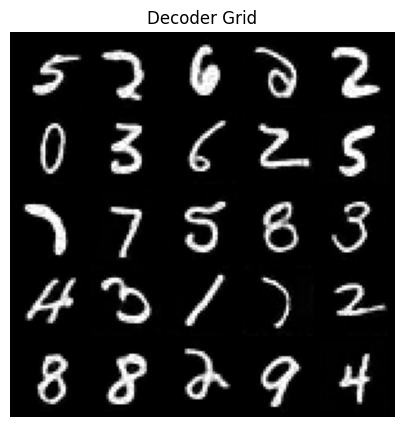

In [2]:

def infer_vqvae(config_file):
    ######## Read the config file #######
    with open(config_file, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    
    dataset_config = config['dataset_params']
    autoencoder_config = config['autoencoder_params']
    train_config = config['train_params']
    
    # Create the dataset
    im_dataset_cls = {
        'mnist': MnistDataset,
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])
    
    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'])
    
    # This is only used for saving latents. Which as of now
    # is not done in batches hence batch size 1
    data_loader = DataLoader(im_dataset,
                             batch_size=1,
                             shuffle=False)

    num_images = train_config['num_samples']
    ngrid = train_config['num_grid_rows']
    
    idxs = torch.randint(0, len(im_dataset) - 1, (num_images,))
    ims = torch.cat([im_dataset[idx][None, :] for idx in idxs]).float()
    ims = ims.to(device)
    
    model = VQVAE(im_channels=dataset_config['im_channels'],
                  model_config=autoencoder_config).to(device)
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name']),
                                     map_location=device))
    model.eval()
    
    with torch.no_grad():
        
        encoded_output, _ = model.encode(ims)
        decoded_output = model.decode(encoded_output)
        encoded_output = torch.clamp(encoded_output, -1., 1.)
        encoded_output = (encoded_output + 1) / 2
        decoded_output = torch.clamp(decoded_output, -1., 1.)
        decoded_output = (decoded_output + 1) / 2
        ims = (ims + 1) / 2

        encoder_grid = make_grid(encoded_output.cpu(), nrow=ngrid)
        decoder_grid = make_grid(decoded_output.cpu(), nrow=ngrid)
        input_grid = make_grid(ims.cpu(), nrow=ngrid)
        encoder_grid = torchvision.transforms.ToPILImage()(encoder_grid)
        decoder_grid = torchvision.transforms.ToPILImage()(decoder_grid)
        input_grid = torchvision.transforms.ToPILImage()(input_grid)
        
        input_grid.save(os.path.join(train_config['task_name'], 'input_samples.png'))
        encoder_grid.save(os.path.join(train_config['task_name'], 'encoded_samples.png'))
        decoder_grid.save(os.path.join(train_config['task_name'], 'reconstructed_samples.png'))
        
        if train_config['save_latents']:
            # save Latents (but in a very unoptimized way)
            latent_path = os.path.join(train_config['task_name'], train_config['vqvae_latent_dir_name'])
            latent_fnames = glob.glob(os.path.join(train_config['task_name'], train_config['vqvae_latent_dir_name'],
                                                   '*.pkl'))
            assert len(latent_fnames) == 0, 'Latents already present. Delete all latent files and re-run'
            if not os.path.exists(latent_path):
                os.mkdir(latent_path)
            print('Saving Latents for {}'.format(dataset_config['name']))
            
            fname_latent_map = {}
            part_count = 0
            count = 0
            for idx, im in enumerate(tqdm(data_loader)):
                encoded_output, _ = model.encode(im.float().to(device))
                fname_latent_map[im_dataset.images[idx]] = encoded_output.cpu()
                # Save latents every 1000 images
                if (count+1) % 1000 == 0:
                    pickle.dump(fname_latent_map, open(os.path.join(latent_path,
                                                                    '{}.pkl'.format(part_count)), 'wb'))
                    part_count += 1
                    fname_latent_map = {}
                count += 1
            if len(fname_latent_map) > 0:
                pickle.dump(fname_latent_map, open(os.path.join(latent_path,
                                                   '{}.pkl'.format(part_count)), 'wb'))
            print('Done saving latents')


    plt.figure(figsize=(5, 5))
    plt.imshow(decoder_grid)
    plt.axis('off')
    plt.title('Decoder Grid')
    plt.show()
   
config_file = 'config/mnist.yaml' # 'config/celebhq.yaml'
infer_vqvae(config_file=config_file)


## Training unconditional LDM

In [ ]:
def train_LDM(config_file):
    # Read the config file #
    with open(config_file, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################
    
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    
    im_dataset_cls = {
        'mnist': MnistDataset,
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])
    
    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=True,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name'])
                                )
    
    data_loader = DataLoader(im_dataset,
                             batch_size=train_config['ldm_batch_size'],
                             shuffle=True)
    
    # Instantiate the model
    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                 model_config=diffusion_model_config).to(device)
    model.train()
    
    # Load VAE ONLY if latents are not to be used or are missing
    if not im_dataset.use_latents:
        print('Loading vqvae model as latents not present')
        vae = VQVAE(im_channels=dataset_config['im_channels'],
                    model_config=autoencoder_model_config).to(device)
        vae.eval()
        # Load vae if found
        if os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['vqvae_autoencoder_ckpt_name'])):
            print('Loaded vae checkpoint')
            vae.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                        train_config['vqvae_autoencoder_ckpt_name']),
                                           map_location=device))
    # Specify training parameters
    num_epochs = train_config['ldm_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['ldm_lr'])
    criterion = torch.nn.MSELoss()
    
    # Run training
    if not im_dataset.use_latents:
        for param in vae.parameters():
            param.requires_grad = False

    loss_all = []

    for epoch_idx in range(num_epochs):
        losses = []
        for im in tqdm(data_loader):
            optimizer.zero_grad()
            im = im.float().to(device)
            if not im_dataset.use_latents:
                with torch.no_grad():
                    im, _ = vae.encode(im)
            
            # Sample random noise
            noise = torch.randn_like(im).to(device)
            
            # Sample timestep
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)
            
            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t)
            
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses)))
        
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']))
        loss_all.append(np.mean(losses))
    print('Done Training ...')
    print('Losses: ', loss_all)

config_file = 'config/mnist.yaml' # 'config/celebhq.yaml'
train_LDM(config_file=config_file)

## Test unconditional LDM

{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_channels': 1, 'im_size': 28, 'name': 'mnist'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0015, 'beta_end': 0.0195}, 'ldm_params': {'down_channels': [128, 256, 256, 256], 'mid_channels': [256, 256], 'down_sample': [False, False, False], 'attn_down': [True, True, True], 'time_emb_dim': 256, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 20, 'down_channels': [32, 64, 128], 'mid_channels': [128, 128], 'down_sample': [True, True], 'attn_down': [False, False], 'norm_channels': 32, 'num_heads': 16, 'num_down_layers': 1, 'num_mid_layers': 1, 'num_up_layers': 1}, 'train_params': {'seed': 1111, 'task_name': 'mnist', 'ldm_batch_size': 128, 'autoencoder_batch_size': 128, 'disc_start': 1000, 'disc_weight': 0.5, 'codebook_weight': 1, 'commitment_beta': 0.2, 'perceptual_weight': 1, 'kl_

/tmp/ipykernel_33173/3879788025.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
/tmp/ipykernel_

Loaded vae checkpoint


1000it [00:11, 84.71it/s]


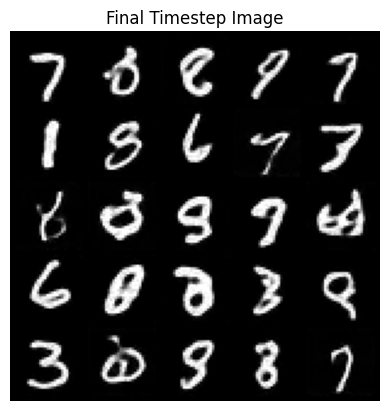

In [3]:
def sample_LDM(model, scheduler, train_config, diffusion_model_config,
               autoencoder_model_config, diffusion_config, dataset_config, vae):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    im_size = dataset_config['im_size'] // 2**sum(autoencoder_model_config['down_sample'])
    xt = torch.randn((train_config['num_samples'],
                      autoencoder_model_config['z_channels'],
                      im_size,
                      im_size)).to(device)

    save_count = 0
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        # Save x0
        #ims = torch.clamp(xt, -1., 1.).detach().cpu()
        if i == 0:
            # Decode ONLY the final iamge to save time
            ims = vae.decode(xt)
        else:
            ims = xt
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)
        # img = img.convert('L')
        if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
            os.mkdir(os.path.join(train_config['task_name'], 'samples'))
        img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
        sample_img = img.copy()
        img.close()

    plt.imshow(sample_img)
    plt.axis('off')
    plt.title('Final Timestep Image')
    plt.show()


def infer_LDM(config_file):
    # Read the config file #
    with open(config_file, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################
    
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    
    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                 model_config=diffusion_model_config).to(device)
    model.eval()
    if os.path.exists(os.path.join(train_config['task_name'],
                                   train_config['ldm_ckpt_name'])):
        print('Loaded unet checkpoint')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                      train_config['ldm_ckpt_name']),
                                         map_location=device))
    # Create output directories
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])
    
    vae = VQVAE(im_channels=dataset_config['im_channels'],
                model_config=autoencoder_model_config).to(device)
    vae.eval()
    
    # Load vae if found
    if os.path.exists(os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name'])):
        print('Loaded vae checkpoint')
        vae.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name']),
                                       map_location=device), strict=True)
    with torch.no_grad():
        sample_LDM(model, scheduler, train_config, diffusion_model_config,
               autoencoder_model_config, diffusion_config, dataset_config, vae)

config_file = 'config/mnist.yaml' # 'config/celebhq.yaml'
infer_LDM(config_file=config_file)